PTH and PTH_FC data analysis 

Importing packages and making storage class

In [1]:
import pandas as pd
import csv
import string
import numpy as np
import matplotlib.pyplot as plt #for plotting
from lmfit import minimize, Parameters, Model, Parameter

In [2]:
#this is a class that stores the data corresponding to each curve or run in one place 
#it makes the code a little neater 
class Run:
    def __init__(self,name="",protein="",concentration=0,model="oneToone",t=[],r=[]):
        self.name = name 
        self.protein = protein 
        self.concentration = concentration
        self.model = model 
        self.t = t 
        self.r = r 
        self.fitResult = None 
    

Loading the data

In [3]:
#making a file list 
letters = string.ascii_uppercase 
dataDir = 'C:/Users/dexte/Desktop/pdata/'
extension = ".xls"
fileNameList = []
for i in range(0,6):
    for j in range(1,5):
        tmpName = letters[i]+str(j)
        fileNameList.append(tmpName)
fileNameList.append('G1')
fileNameList.append('G3')
fileNameList.append('H1')
fileNameList.append('H3')
fileList = [] 
for name in fileNameList:
    fileList.append(dataDir+name+extension)

print(fileList)

['C:/Users/dexte/Desktop/pdata/A1.xls', 'C:/Users/dexte/Desktop/pdata/A2.xls', 'C:/Users/dexte/Desktop/pdata/A3.xls', 'C:/Users/dexte/Desktop/pdata/A4.xls', 'C:/Users/dexte/Desktop/pdata/B1.xls', 'C:/Users/dexte/Desktop/pdata/B2.xls', 'C:/Users/dexte/Desktop/pdata/B3.xls', 'C:/Users/dexte/Desktop/pdata/B4.xls', 'C:/Users/dexte/Desktop/pdata/C1.xls', 'C:/Users/dexte/Desktop/pdata/C2.xls', 'C:/Users/dexte/Desktop/pdata/C3.xls', 'C:/Users/dexte/Desktop/pdata/C4.xls', 'C:/Users/dexte/Desktop/pdata/D1.xls', 'C:/Users/dexte/Desktop/pdata/D2.xls', 'C:/Users/dexte/Desktop/pdata/D3.xls', 'C:/Users/dexte/Desktop/pdata/D4.xls', 'C:/Users/dexte/Desktop/pdata/E1.xls', 'C:/Users/dexte/Desktop/pdata/E2.xls', 'C:/Users/dexte/Desktop/pdata/E3.xls', 'C:/Users/dexte/Desktop/pdata/E4.xls', 'C:/Users/dexte/Desktop/pdata/F1.xls', 'C:/Users/dexte/Desktop/pdata/F2.xls', 'C:/Users/dexte/Desktop/pdata/F3.xls', 'C:/Users/dexte/Desktop/pdata/F4.xls', 'C:/Users/dexte/Desktop/pdata/G1.xls', 'C:/Users/dexte/Desktop/

In [4]:
#fileList = ['C:/Users/dexte/Desktop/pdata/A1.xls', 'C:/Users/dexte/Desktop/pdata/A2.xls', 'C:/Users/dexte/Desktop/pdata/A3.xls', 'C:/Users/dexte/Desktop/pdata/A4.xls', 'C:/Users/dexte/Desktop/pdata/B1.xls', 'C:/Users/dexte/Desktop/pdata/B2.xls', 'C:/Users/dexte/Desktop/pdata/B3.xls', 'C:/Users/dexte/Desktop/pdata/B4.xls', 'C:/Users/dexte/Desktop/pdata/C1.xls', 'C:/Users/dexte/Desktop/pdata/C2.xls', 'C:/Users/dexte/Desktop/pdata/C3.xls', 'C:/Users/dexte/Desktop/pdata/C4.xls', 'C:/Users/dexte/Desktop/pdata/D1.xls', 'C:/Users/dexte/Desktop/pdata/D2.xls', 'C:/Users/dexte/Desktop/pdata/D3.xls', 'C:/Users/dexte/Desktop/pdata/D4.xls', 'C:/Users/dexte/Desktop/pdata/E1.xls', 'C:/Users/dexte/Desktop/pdata/E2.xls', 'C:/Users/dexte/Desktop/pdata/E3.xls', 'C:/Users/dexte/Desktop/pdata/E4.xls', 'C:/Users/dexte/Desktop/pdata/F1.xls', 'C:/Users/dexte/Desktop/pdata/F2.xls', 'C:/Users/dexte/Desktop/pdata/F3.xls', 'C:/Users/dexte/Desktop/pdata/F4.xls', 'C:/Users/dexte/Desktop/pdata/F4.xls', 'C:/Users/dexte/Desktop/pdata/G1.xls', 'C:/Users/dexte/Desktop/pdata/G3.xls', 'C:/Users/dexte/Desktop/pdata/H1.xls', 'C:/Users/dexte/Desktop/pdata/H3.xls']
#this identifies the curves corresponding to PTF-Fc proteins. The other ones are the PTH
isFc = [0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1,0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1,0, 0, 1,0,1]

#this reads the data from all of the files, builds a Run object, and then stores it in the run_array object 
t_array = []
r_array = []
run_array = []
conc_array = []
run_num = 0
for file in fileList:
    with open(file,'r') as csvFile:
        rowNum = 1 
        fReader = csv.reader(csvFile)
        conc = 0 
        t = []
        r = []
        for row in fReader:
            if(rowNum==2):
                conc = row[0].split("\t")[1]
            if(rowNum >= 6): 
                t.append(float(row[0].split("\t")[0]))
                r.append(float(row[0].split("\t")[1]))


            rowNum = rowNum + 1 
    t_array.append(t)
    r_array.append(r)
    conc_array.append(conc)
    
    if(isFc[run_num]):
        protein_name = "PTH-Fc"
    else:
        protein_name = "PTH"
    
    tmpRun = Run(str(run_num),protein_name,conc,"oneToone",t,r)
    run_array.append(tmpRun)
    
    run_num = run_num + 1 


Making a PTH and PTH-Fc graph while ignoring the curves that have a max below 0.07 nm 

0 1E-05
4 6.7E-06
8 4.4E-06
12 3E-06
16 2E-06
20 1.3E-06
24 8.8E-07


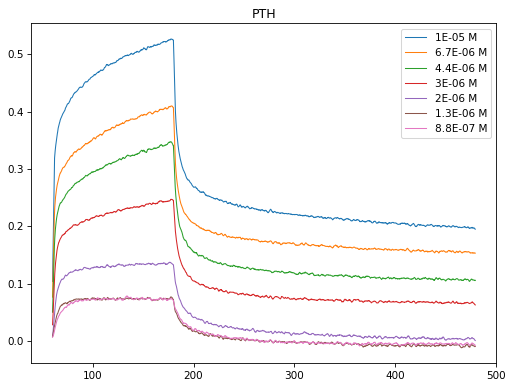

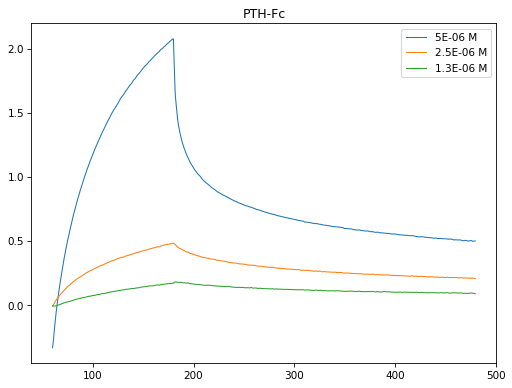

In [5]:
k=0
for run in run_array:
    if(run.protein == "PTH-Fc" and np.max(run.r)>0.07):
        plt.figure(1,figsize=(8, 6), dpi=75, facecolor='w', edgecolor='k')
        conc = run.concentration
        plt.plot(run.t,run.r,'-',linewidth=1,label=str(conc) + " M")
        plt.legend()
        plt.title("PTH-Fc")
    if(run.protein=="PTH" and np.max(run.r)>0.07):
        plt.figure(2,figsize=(8, 6), dpi=75, facecolor='w', edgecolor='k')
        conc = run.concentration
        plt.plot(run.t,run.r,'-',linewidth=1,label=str(conc) + " M")
        plt.legend()
        plt.title("PTH")
        print(k,conc) #this is for testing purposes to find the positions in run array that cor to PTH 
    k=k+1

#plt.figure(1)

#print(i,j)

In [6]:
#this peice of code is important. It locates the position where the max peak is reached 

i = np.max(run_array[0].r)
max_value = max(run_array[0].r)
max_index = run_array[0].r.index(max_value)
max_time = run_array[0].t[max_index]
tmax = max_time 


Now we are going to get involved in fitting!
First we will do the one-to-one fitting.
The one to one fitting follows the following model:  
$L+A \underset{k_a}{\stackrel{k_d}{\rightleftharpoons}} LA$
The differential equations for this model are:

$\begin{equation}
\frac{d[L]}{dt} = - (k_a[L][A]-k_d[LA])
\end{equation}$

$\begin{equation}
\frac{d[LA]}{dt}=k_a[L][A]-k_d[LA]
\end{equation}$

The integrated equations that we will be fitting to the models are shown below 

for the absorption part: 

$R = R_{eq}(1-e^{-(k_aC+k_d)(t-t_0)})$

for the desportion part: 

$R=R_{0}e^{-k_d(t-t_0)}$

$R_{0} = R_{absFit}(t_{change over})$


$R_{eq} = \frac{k_aC}{k_aC+k_d}R_{max}$

So the variables varried in the fit are $R_{max}$, $k_d$ and $k_a$

In [7]:
i = np.max(run_array[0].r)
max_value = max(run_array[0].r)
max_index = run_array[0].r.index(max_value)
max_time = run_array[0].t[max_index]
tmax = max_time 

#absorption and desoprtion combined together 

#parameters from BLI program's global fit for initial guess for one of the fittings 
#this provides a good starting point for all of the graphs 

kon = 9.32e4
kdis = 3.45e-2
Rmaxf = 0.1551 

for aRun in run_array: 
    tmpRun = aRun
    tp = np.array(tmpRun.t) #max index only fits first part 
    rp = np.array(tmpRun.r)
    A0 = float(tmpRun.concentration)
    t0 = tp[0]

    def absdes(t,ka,kd,Rmax,A0,t0,tmax,imax):#absoprtion and desoprtion 
        np.zeros(len(t))
        tOnes = np.ones(len(t))
        isAbs = np.asarray(t)<tmax
        isDes =  np.invert(isAbs)
        Rest_abs = Rmax*((ka*A0)/(ka*A0+kd))*(1-np.exp(-(ka*A0+kd)*(t-t0)))
        R0 = Rest_abs[imax]
        Rest_des = R0*( np.exp(-kd*(t-tmax)*isDes) )
        return Rest_abs*isAbs +Rest_des*isDes

    aModel = Model(absdes)

    params = aModel.make_params()
    params["kd"] = Parameter(name="kd",value=kdis,min=0)
    params["ka"] = Parameter(name="ka",value=kon,min=0)
    params["Rmax"] = Parameter(name="Rmax",value=Rmaxf,min=0)

    params["A0"] = Parameter(name="A0",value=A0,vary=False) 
    params["t0"] = Parameter(name="t0",value=t0,vary=False) 
    params["tmax"] = Parameter(name="tmax",value=tmax,vary=False) 
    params["imax"] = Parameter(name="imax",value=max_index,vary=False) 

    result = aModel.fit(rp,params,t=tp)
    print(result.fit_report())
    aRun.fitResult = result


[[Model]]
    Model(absdes)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 2100
    # variables        = 3
    chi-square         = 8.53562466
    reduced chi-square = 0.00407040
    Akaike info crit   = -11555.4326
    Bayesian info crit = -11538.4835
[[Variables]]
    ka:    59596.8208 +/- 6363.91175 (10.68%) (init = 93200)
    kd:    0.00403749 +/- 6.2874e-05 (1.56%) (init = 0.0345)
    Rmax:  0.42426507 +/- 0.00239169 (0.56%) (init = 0.1551)
    A0:    1e-05 (fixed)
    t0:    60 (fixed)
    tmax:  178 (fixed)
    imax:  590 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(kd, Rmax) =  0.562
    C(ka, Rmax) = -0.277

[[Model]]
    Model(absdes)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 2100
    # variables        = 3
    chi-square         = 0.03384496
    reduced chi-square = 1.6140e-05
    Akaike info crit   = -23168.8813
    Bayesian info c

[[Model]]
    Model(absdes)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 2332
    # data points      = 2100
    # variables        = 3
    chi-square         = 0.07512007
    reduced chi-square = 3.5823e-05
    Akaike info crit   = -21494.5564
    Bayesian info crit = -21477.6073
[[Variables]]
    ka:    0.55186229 +/- 1105.99813 (200411.98%) (init = 93200)
    kd:    0.00142592 +/- 5.2080e-05 (3.65%) (init = 0.0345)
    Rmax:  1037.76139 +/- 2067045.65 (199183.13%) (init = 0.1551)
    A0:    6.3e-07 (fixed)
    t0:    60 (fixed)
    tmax:  178 (fixed)
    imax:  590 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(ka, Rmax) = -1.000
    C(kd, Rmax) =  0.465
    C(ka, kd)   = -0.465

[[Model]]
    Model(absdes)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 27
    # data points      = 2100
    # variables        = 3
    chi-square         = 0.42658654
    reduced chi-square = 2.0343e-04
    Akaike info cr

now we plot each graph with its fit and we also calculate $K_D$ here

KD is 

  conc              KD
{8.8e-07: 6.001758729285574e-07,
 1.3e-06: 5.960187564727985e-07,
 2e-06: 4.5236781431639415e-07,
 2.5e-06: 3.126367528781236e-07,
 3e-06: 5.8849748755496075e-08,
 4.4e-06: 6.179387535998014e-08,
 5e-06: 1.0745550569444621e-06,
 6.7e-06: 5.363825062106822e-08,
 1e-05: 6.774678758156255e-08}


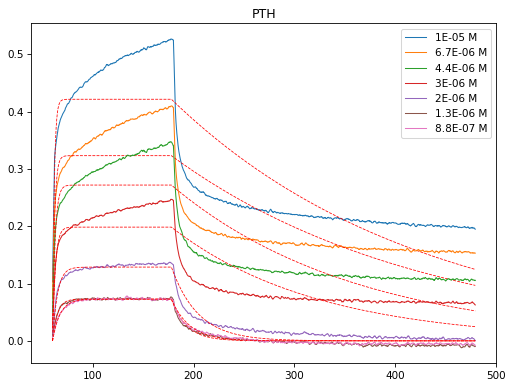

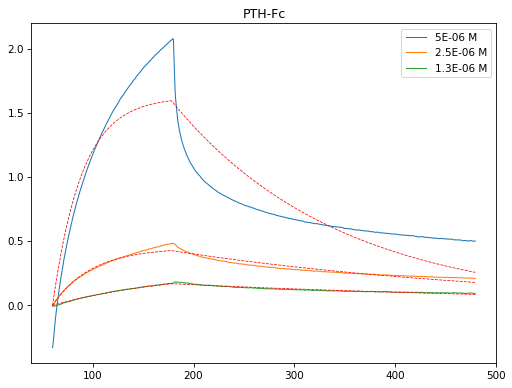

In [8]:
KdDic = {}
for run in run_array:
    if(run.protein == "PTH-Fc" and np.max(run.r)>0.07):
        plt.figure(1,figsize=(8, 6), dpi=75, facecolor='w', edgecolor='k')
        conc = run.concentration
        plt.plot(run.t,run.r,'-',linewidth=1,label=str(conc) + " M")
        plt.plot(run.t,run.fitResult.best_fit,"--r",linewidth=0.75)
        plt.legend()
        plt.title("PTH-Fc")
        #print(run.fitResult.fit_report())
        KdDic[run.fitResult.params["A0"].value]= run.fitResult.params["kd"].value/run.fitResult.params["ka"].value

    if(run.protein=="PTH" and np.max(run.r)>0.07):
        plt.figure(2,figsize=(8, 6), dpi=75, facecolor='w', edgecolor='k')
        conc = run.concentration
        plt.plot(run.t,run.r,'-',linewidth=1,label=str(conc) + " M")
        plt.plot(run.t,run.fitResult.best_fit,"--r",linewidth=0.75)
        plt.legend()
        plt.title("PTH")
        KdDic[run.fitResult.params["A0"].value]= run.fitResult.params["kd"].value/run.fitResult.params["ka"].value
        #print(run.fitResult.fit_report())
print("KD is \n")
print("  conc              KD")
import pprint
pprint.pprint(KdDic)
pretty_dict_str = pprint.pformat(KdDic)


Here we fit another model. The double binding model. 